In [1]:
import pandas as pd

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.model_selection import cross_val_score
%matplotlib inline
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_recall_fscore_support,precision_score,recall_score,f1_score
from IPython.display import display
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix


pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

plt.style.use('ggplot')

def randomised_search_cv(classifier,parameters,df,col_list,labels,num_iter=500):
    accuracy_list = []
    RSEED = 42
    for i in range(num_iter):
        
        if i%(num_iter/4)==0:
            print(str(i)+"iterations ran")

        param_iter = {}
        for key,value in parameters.items():
            param_iter[key] = random.choice(value)
        clf = classifier(random_state=RSEED, **param_iter)

        scores = cross_val_score(clf, df[col_list], labels, cv=5,scoring="f1")
        accuracy_list += [(param_iter, np.mean(scores))]

    accuracy_list.sort(key = lambda x: x[1])
    print(accuracy_list[-1])
    return accuracy_list[-1]

def generate_prc(y_true, y_proba):
    return precision_recall_curve(y_true, y_proba[:, 1])

def plot_curves(clf_curves, ctype='roc', legend=False):
    clfs = clf_curves.keys()
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    for clf, curve in clf_curves.items():
        if ctype == 'roc':
            x = curve[0]
            y = curve[1]
            xlabel = 'False Positive Rate'
            ylabel = 'True Positive Rate'
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
        if ctype == 'prc':
            x = curve[1]
            y = curve[0]
            xlabel = 'Recall'
            ylabel = 'Precision'
        if 'all' in clf:
            ax.plot(x, y, lw=3, color='k', label='%s AUC: %.4f' % (clf, auc(x, y)))
        else:
            ax.plot(x, y, lw=2, alpha=0.5, label='%s AUC: %.4f' % (clf, auc(x, y)))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if legend:
        ax.legend(loc='best', fontsize=10)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_yticks(np.linspace(0, 1, 11))
    
    
def modelbuilder(classifier,parameters,train_data,test_data,col_list,train_labels,test_labels,holdout_df,title):
    clf = classifier(**parameters)
    trained_model = clf.fit(train_data[col_list], train_labels)
    print("Precision on train",precision_score(train_labels,clf.predict(train_data[col_list])) )
    print("Recall on train",recall_score(train_labels,clf.predict(train_data[col_list])) )
    print("F1 score on train",f1_score(train_labels,clf.predict(train_data[col_list])) )
#     params = {"verbose":0}
    
#     trained_model.set_params(**parameters)
    y_pred = clf.predict_proba(test_data[col_list])
    inc_prc = generate_prc(test_labels, y_pred)
    plot_curves({title: inc_prc}, ctype='prc', legend=True)
    y_predicted = clf.predict(test_data[col_list])
    prec_score= precision_score(test_labels,y_predicted)
    rec_score= recall_score(test_labels,y_predicted)
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("Precision on test:",prec_score)
    print("Recall on test:",rec_score)
    print("F1 Score on test: ",f1)
    print(confusion_matrix(test_labels, y_predicted))
    holdout_df = holdout_df.copy()
    holdout_df['is_promoted'] = clf.predict(holdout_df[col_list])
    holdout_df[['employee_id','is_promoted']].to_csv("../submissions/"+title+".csv",index=False)

In [3]:
train = pd.read_csv("../datasets/train_LZdllcl.csv")

In [4]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [5]:
train.shape

(54808, 14)

In [6]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [7]:
train['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [8]:
event_rate = train['is_promoted'].mean()

In [9]:
train['is_promoted'].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [10]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [11]:
for col in ['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score']:
    print(col,train[col].nunique())

department 9
region 34
education 3
gender 2
recruitment_channel 3
no_of_trainings 10
age 41
previous_year_rating 5
length_of_service 35
KPIs_met >80% 2
awards_won? 2
avg_training_score 61


In [12]:
def age(num):
    if  20 <= num < 25:
        return "[20-25)"
    elif 25 <= num < 30:
        return "[25-30)"
    elif 30 <= num < 35:
        return "[30-35)"
    elif 35 <= num < 40:
        return "[35-40)"
    elif 40 <= num < 50:
        return "[40-50)"
    else:
        return ">=50"

In [13]:
train['education'] = train['education'].fillna("Missing")

train['previous_year_rating'] = train['previous_year_rating'].fillna(3)



train['age_bin'] = list(map(lambda x: age(x), train['age']))

In [14]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted', 'age_bin'],
      dtype='object')

In [15]:
dummy_col_list = ['department', 'region', 'education', 'gender','recruitment_channel','age_bin']

In [16]:
for col in dummy_col_list:
    print(train.groupby([col]).agg({'is_promoted':'mean'}).reset_index().rename(columns={'is_promoted':'event_rate'}).sort_values(by='event_rate',ascending=False))

          department  event_rate
8         Technology    0.107593
5        Procurement    0.096386
0          Analytics    0.095665
4         Operations    0.090148
1            Finance    0.081230
7  Sales & Marketing    0.072031
6                R&D    0.069069
2                 HR    0.056245
3              Legal    0.051011
       region  event_rate
28   region_4    0.144451
8   region_17    0.136935
17  region_25    0.125763
20  region_28    0.116844
15  region_23    0.116596
14  region_22    0.114188
22   region_3    0.106936
31   region_7    0.106546
0    region_1    0.095082
23  region_30    0.089802
4   region_13    0.086858
32   region_8    0.080916
11   region_2    0.080126
6   region_15    0.079060
19  region_27    0.078963
1   region_10    0.078704
5   region_14    0.074970
7   region_16    0.069625
3   region_12    0.066000
18  region_26    0.063274
10  region_19    0.060641
12  region_20    0.057647
24  region_31    0.056848
2   region_11    0.056274
30   region_6    0.0

In [17]:
train2 = pd.get_dummies(train,columns=dummy_col_list)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train2[[x for x in train2.columns if x not in ['is_promoted','employee_id']]], train2['is_promoted'], test_size=0.3, random_state=1)

In [19]:
X_train.shape

(38365, 65)

In [20]:
test = pd.read_csv("../datasets/test_2umaH9m.csv")

In [21]:
print(test.isnull().sum())

test['education'] = test['education'].fillna("Missing")

test['previous_year_rating'] = test['previous_year_rating'].fillna(3)
test['age_bin'] = list(map(lambda x: age(x), test['age']))
print(test.isnull().sum())

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64
employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
age_bin                 0
dtype: int64


In [22]:
for col in dummy_col_list:
    print(col,test[col].nunique())

department 9
region 34
education 4
gender 2
recruitment_channel 3
age_bin 6


In [23]:
test_processed = pd.get_dummies(test,columns=dummy_col_list)
print(test_processed.shape)

(23490, 66)


0iterations ran
125iterations ran
250iterations ran
375iterations ran
({'max_features': None, 'splitter': 'best', 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 0.04, 'min_samples_leaf': 0.015, 'min_impurity_decrease': 0.01}, 0.23317673738336325)
Precision on train 0.6346414073071719
Recall on train 0.14285714285714285
F1 score on train 0.2332173048234709
Precision on test: 0.6196319018404908
Recall on test: 0.14584837545126353
F1 Score on test:  0.23611922852133255
[[14934   124]
 [ 1183   202]]


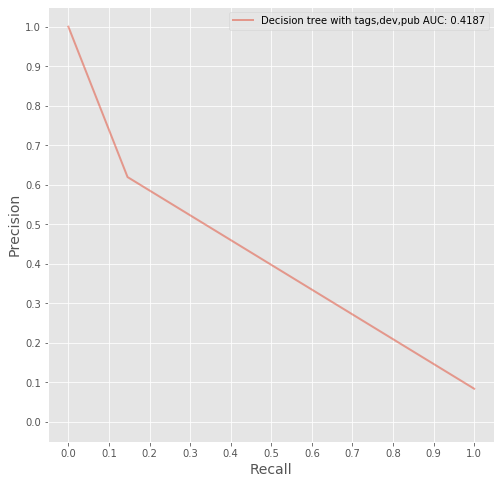

In [24]:
col_list = [x for x in train2.columns if x not in ['is_promoted','employee_id']]

parameters_dt = {'max_features':['auto', 'sqrt', 'log2',None],'splitter':['best'], 'criterion':['gini', 'entropy'], 'max_depth':[2,3,4,5,6,7,8,9,10], 'min_samples_split':[.005,.01,.015,.02,.025,.03,.035,.04,.045,.05], 'min_samples_leaf':[.005,.01,.015,.02,.025,.03,.035,.04,.045,.05], 'min_impurity_decrease':list(np.arange(0,0.11,.01)) }
accuracy_dt = randomised_search_cv(DecisionTreeClassifier,parameters_dt,X_train,col_list,y_train,num_iter=500)
modelbuilder(DecisionTreeClassifier,accuracy_dt[0],X_train,X_test,col_list,y_train,y_test,test_processed,"Decision tree with tags,dev,pub")

0iterations ran
({'n_estimators': 250, 'max_features': None, 'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.0}, 0.4251766330267081)
Precision on train 0.998019801980198
Recall on train 0.3070362473347548
F1 score on train 0.46960167714884704
Precision on test: 0.9539170506912442
Recall on test: 0.29891696750902524
F1 Score on test:  0.45519516217702033
[[15038    20]
 [  971   414]]


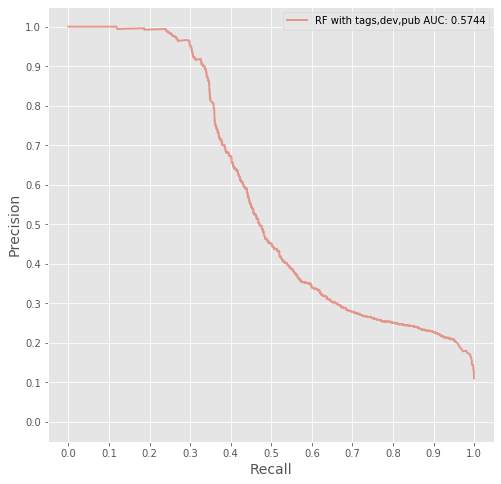

In [25]:
col_list = ['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'department_Analytics',
 'department_Finance',
 'department_HR',
 'department_Legal',
 'department_Operations',
 'department_Procurement',
 'department_R&D',
 'department_Sales & Marketing',
 'department_Technology',
 'region_region_1',
 'region_region_10',
 'region_region_11',
 'region_region_12',
 'region_region_13',
 'region_region_14',
 'region_region_15',
 'region_region_16',
 'region_region_17',
 'region_region_18',
 'region_region_19',
 'region_region_2',
 'region_region_20',
 'region_region_21',
 'region_region_22',
 'region_region_23',
 'region_region_24',
 'region_region_25',
 'region_region_26',
 'region_region_27',
 'region_region_28',
 'region_region_29',
 'region_region_3',
 'region_region_30',
 'region_region_31',
 'region_region_32',
 'region_region_33',
 'region_region_34',
 'region_region_4',
 'region_region_5',
 'region_region_6',
 'region_region_7',
 'region_region_8',
 'region_region_9',
 "education_Bachelor's",
 'education_Below Secondary',
 "education_Master's & above",
 'education_Missing',
 'gender_f',
 'gender_m',
 'recruitment_channel_other',
 'recruitment_channel_referred',
 'recruitment_channel_sourcing']

parameters_rf = {'n_estimators':[100,500,250],'max_features':['sqrt', 'log2',None], 'criterion':['gini', 'entropy'], 'max_depth':[3,4,5,6,7,8,9,10], 'min_impurity_decrease':list(np.arange(0,0.11,.01)) }
accuracy_rf = randomised_search_cv(RandomForestClassifier,parameters_rf,X_train,col_list,y_train,num_iter=25)
modelbuilder(RandomForestClassifier,accuracy_rf[0],X_train,X_test,col_list,y_train,y_test,test_processed,"RF with tags,dev,pub")


In [26]:
model1_parameters = accuracy_rf[0]

model1_feature_set = ['no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'department_Analytics',
 'department_Finance',
 'department_HR',
 'department_Legal',
 'department_Operations',
 'department_Procurement',
 'department_R&D',
 'department_Sales & Marketing',
 'department_Technology',
 'region_region_1',
 'region_region_10',
 'region_region_11',
 'region_region_12',
 'region_region_13',
 'region_region_14',
 'region_region_15',
 'region_region_16',
 'region_region_17',
 'region_region_18',
 'region_region_19',
 'region_region_2',
 'region_region_20',
 'region_region_21',
 'region_region_22',
 'region_region_23',
 'region_region_24',
 'region_region_25',
 'region_region_26',
 'region_region_27',
 'region_region_28',
 'region_region_29',
 'region_region_3',
 'region_region_30',
 'region_region_31',
 'region_region_32',
 'region_region_33',
 'region_region_34',
 'region_region_4',
 'region_region_5',
 'region_region_6',
 'region_region_7',
 'region_region_8',
 'region_region_9',
 "education_Bachelor's",
 'education_Below Secondary',
 "education_Master's & above",
 'education_Missing',
 'gender_f',
 'gender_m',
 'recruitment_channel_other',
 'recruitment_channel_referred',
 'recruitment_channel_sourcing']

model1_clf = RandomForestClassifier(**model1_parameters,random_state=42)
trained_model1 = model1_clf.fit(X_train[model1_feature_set], y_train)
print("Precision on train",precision_score(y_train,model1_clf.predict(X_train[model1_feature_set])) )
print("Recall on train",recall_score(y_train,model1_clf.predict(X_train[model1_feature_set])) )
print("F1 score on train",f1_score(y_train,model1_clf.predict(X_train[model1_feature_set])) )
print("\n")
model1_df = pd.DataFrame()
model1_df['employee_id'] = train['employee_id']
model1_df['is_promoted'] = train['is_promoted']
model1_df['probability'] = [x[1] for x in model1_clf.predict_proba(train2[model1_feature_set])]
print("Average probability ",model1_df['probability'].mean())
print("\n")


for threshold in list(np.arange(0.1,0.5,.05))+[event_rate]:
    model1_df['threshold_'+str(threshold)+"pred"] = list(map(lambda x: 1 if x>= threshold else 0, model1_df['probability']))
    prec_score= precision_score(model1_df['is_promoted'],model1_df['threshold_'+str(threshold)+"pred"])
    rec_score= recall_score(model1_df['is_promoted'],model1_df['threshold_'+str(threshold)+"pred"])
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("threshold -> ", threshold)
    print("Precision on Full_data:",prec_score)
    print("Recall on Full_data:",rec_score)
    print("F1 Score on Full_data: ",f1)
    print(confusion_matrix(model1_df['is_promoted'], model1_df['threshold_'+str(threshold)+"pred"]))
    print("\n")
    

Precision on train 0.9970443349753695
Recall on train 0.30825464514163875
F1 score on train 0.47091670544439274


Average probability  0.08532296938520714


threshold ->  0.1
Precision on Full_data: 0.21569878749202298
Recall on Full_data: 0.9413024850042845
F1 Score on Full_data:  0.35097248292663447
[[34163 15977]
 [  274  4394]]


threshold ->  0.15000000000000002
Precision on Full_data: 0.3167008005957922
Recall on Full_data: 0.7287917737789203
F1 Score on Full_data:  0.4415314730694354
[[42800  7340]
 [ 1266  3402]]


threshold ->  0.20000000000000004
Precision on Full_data: 0.5977594025073353
Recall on Full_data: 0.4800771208226221
F1 Score on Full_data:  0.5324937626232624
[[48632  1508]
 [ 2427  2241]]


threshold ->  0.25000000000000006
Precision on Full_data: 0.7535014005602241
Recall on Full_data: 0.4033847472150814
F1 Score on Full_data:  0.5254639319101437
[[49524   616]
 [ 2785  1883]]


threshold ->  0.30000000000000004
Precision on Full_data: 0.8531883341571923
Recall o

In [27]:
train2['sum_metric'] = train2['awards_won?']+train2['KPIs_met >80%'] + train2['previous_year_rating']
test_processed['sum_metric'] = test_processed['awards_won?']+test_processed['KPIs_met >80%'] + test_processed['previous_year_rating']

train2['tot_score'] = train2['avg_training_score'] * train2['no_of_trainings']
test_processed['tot_score'] = test_processed['avg_training_score'] * test_processed['no_of_trainings']


train2['work_fraction'] = train2['length_of_service'] / train2['age']
test_processed['work_fraction'] = test_processed['length_of_service'] / test_processed['age']
train2['start_year'] = train2['age'] - train2['length_of_service']
test_processed['start_year'] = test_processed['age'] - test_processed['length_of_service']

In [28]:
ana1 = train.groupby(['region','department']).agg({'avg_training_score':'mean'}).reset_index().rename(columns={'avg_training_score':'avg_training_score_reg_dpt'})

cross_train_data = pd.merge(train[['region','department','avg_training_score']],ana1,on=['region','department'],how='left')

cross_train_data['better_in_dept_reg'] = list(map(lambda x,y: 1 if x>y else 0 , cross_train_data['avg_training_score'],cross_train_data['avg_training_score_reg_dpt']))

cross_test_data = pd.merge(test[['region','department','avg_training_score']],ana1,on=['region','department'],how='left')
cross_test_data['better_in_dept_reg'] = list(map(lambda x,y: 1 if x>y else 0 , cross_test_data['avg_training_score'],cross_test_data['avg_training_score_reg_dpt']))

In [29]:
train3 = pd.merge(train2,cross_train_data,left_index=True,right_index=True,how="left")
test_processed2 = pd.merge(test_processed,cross_test_data,left_index=True,right_index=True,how='left')

In [31]:
train3.columns

Index(['employee_id', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score_x', 'is_promoted', 'department_Analytics',
       'department_Finance', 'department_HR', 'department_Legal',
       'department_Operations', 'department_Procurement', 'department_R&D',
       'department_Sales & Marketing', 'department_Technology',
       'region_region_1', 'region_region_10', 'region_region_11',
       'region_region_12', 'region_region_13', 'region_region_14',
       'region_region_15', 'region_region_16', 'region_region_17',
       'region_region_18', 'region_region_19', 'region_region_2',
       'region_region_20', 'region_region_21', 'region_region_22',
       'region_region_23', 'region_region_24', 'region_region_25',
       'region_region_26', 'region_region_27', 'region_region_28',
       'region_region_29', 'region_region_3', 'region_region_30',
       'region_region_31', 'region_region_32', 'region_regi

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train3[[ 'age_bin_>=50', 'age_bin_[20-25)',
       'age_bin_[25-30)', 'age_bin_[30-35)', 'age_bin_[35-40)',
       'age_bin_[40-50)', 'sum_metric', 'tot_score', 'work_fraction',
       'start_year', 'better_in_dept_reg']], train2['is_promoted'], test_size=0.3, random_state=1)


0iterations ran
5iterations ran
10iterations ran
15iterations ran
({'n_estimators': 500, 'max_features': None, 'criterion': 'entropy', 'max_depth': 8, 'min_impurity_decrease': 0.0}, 0.19303348868776504)
Precision on train 0.9278846153846154
Recall on train 0.11757538836430094
F1 score on train 0.2087050554203839
Precision on test: 0.8288770053475936
Recall on test: 0.11191335740072202
F1 Score on test:  0.19720101781170482
[[15026    32]
 [ 1230   155]]


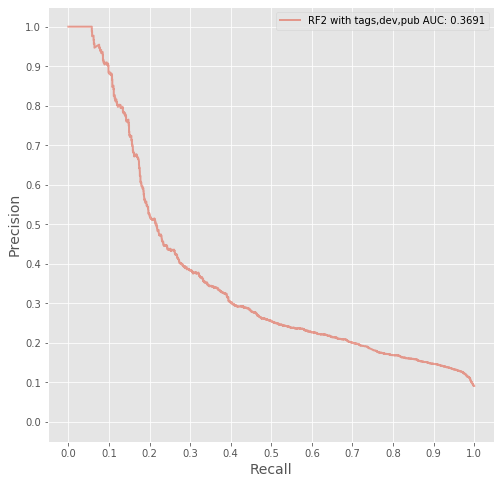

In [33]:
col_list = [ 'age_bin_>=50', 'age_bin_[20-25)',
       'age_bin_[25-30)', 'age_bin_[30-35)', 'age_bin_[35-40)',
       'age_bin_[40-50)', 'sum_metric', 'tot_score', 'work_fraction',
       'start_year', 'better_in_dept_reg']

parameters_rf = {'n_estimators':[100,500,250],'max_features':['sqrt', 'log2',None], 'criterion':['gini', 'entropy'], 'max_depth':[3,4,5,6,7,8,9,10], 'min_impurity_decrease':list(np.arange(0,0.11,.01)) }
accuracy_rf2 = randomised_search_cv(RandomForestClassifier,parameters_rf,X_train,col_list,y_train,num_iter=20)
modelbuilder(RandomForestClassifier,accuracy_rf2[0],X_train,X_test,col_list,y_train,y_test,test_processed2,"RF2 with tags,dev,pub")


In [34]:
model2_parameters = accuracy_rf2[0]

model2_feature_set = [ 'age_bin_>=50', 'age_bin_[20-25)',
       'age_bin_[25-30)', 'age_bin_[30-35)', 'age_bin_[35-40)',
       'age_bin_[40-50)', 'sum_metric', 'tot_score', 'work_fraction',
       'start_year', 'better_in_dept_reg']

model2_clf = RandomForestClassifier(**model2_parameters,random_state=42)
trained_model2 = model2_clf.fit(X_train[model2_feature_set], y_train)
print("Precision on train",precision_score(y_train,model2_clf.predict(X_train[model2_feature_set])) )
print("Recall on train",recall_score(y_train,model2_clf.predict(X_train[model2_feature_set])) )
print("F1 score on train",f1_score(y_train,model2_clf.predict(X_train[model2_feature_set])) )
print("\n")
model2_df = pd.DataFrame()
model2_df['employee_id'] = train['employee_id']
model2_df['is_promoted'] = train['is_promoted']
model2_df['probability'] = [x[1] for x in model2_clf.predict_proba(train3[model2_feature_set])]
print("Average probability ",model2_df['probability'].mean())
print("\n")


for threshold in list(np.arange(0.1,0.5,.05))+[event_rate]:
    model2_df['threshold_'+str(threshold)+"pred"] = list(map(lambda x: 1 if x>= threshold else 0, model2_df['probability']))
    prec_score= precision_score(model2_df['is_promoted'],model2_df['threshold_'+str(threshold)+"pred"])
    rec_score= recall_score(model2_df['is_promoted'],model2_df['threshold_'+str(threshold)+"pred"])
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("threshold -> ", threshold)
    print("Precision on Full_data:",prec_score)
    print("Recall on Full_data:",rec_score)
    print("F1 Score on Full_data: ",f1)
    print(confusion_matrix(model2_df['is_promoted'], model2_df['threshold_'+str(threshold)+"pred"]))
    print("\n")
    

Precision on train 0.9228971962616822
Recall on train 0.12031678342978983
F1 score on train 0.21288062516841819


Average probability  0.0854422047275832


threshold ->  0.1
Precision on Full_data: 0.2114334785008894
Recall on Full_data: 0.7384318766066839
F1 Score on Full_data:  0.32873968814076576
[[37284 12856]
 [ 1221  3447]]


threshold ->  0.15000000000000002
Precision on Full_data: 0.31549223462970094
Recall on Full_data: 0.5265638389031705
F1 Score on Full_data:  0.39457420338710975
[[44807  5333]
 [ 2210  2458]]


threshold ->  0.20000000000000004
Precision on Full_data: 0.37892095357590966
Recall on Full_data: 0.38817480719794345
F1 Score on Full_data:  0.3834920634920635
[[47170  2970]
 [ 2856  1812]]


threshold ->  0.25000000000000006
Precision on Full_data: 0.4106722469264975
Recall on Full_data: 0.3363324764353042
F1 Score on Full_data:  0.36980332116358494
[[47887  2253]
 [ 3098  1570]]


threshold ->  0.30000000000000004
Precision on Full_data: 0.5682676740420939
Recal

In [35]:
train3 = train3.rename(columns={'avg_training_score_x':'avg_training_score'}).drop(columns=['avg_training_score_y'])

In [36]:
test_processed2 = test_processed2.rename(columns={'avg_training_score_x':'avg_training_score'}).drop(columns=['avg_training_score_y'])

In [37]:
list_for_operations = ['no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'age_bin_>=50', 'age_bin_[20-25)',
       'age_bin_[25-30)', 'age_bin_[30-35)', 'age_bin_[35-40)',
       'age_bin_[40-50)', 'sum_metric', 'tot_score', 'work_fraction',
       'start_year', 'better_in_dept_reg']
train4 = train3[list_for_operations].copy()
test_processed3 = test_processed2[['employee_id']+list_for_operations].copy()

In [38]:
new_col_list = []
for col1 in list_for_operations:
    for col2 in list_for_operations:
        var_name1 = col1+"_mul_"+col2
        
        
        train4[var_name1] = list(map(lambda x,y: x*y , train4[col1],train4[col2]))
        if train4[var_name1].sum() != 0:
            new_col_list += [var_name1]
        if col1!= col2:
            var_name2 = col1+"_div_"+col2
            train4[var_name2] = list(map(lambda x,y: x/y if y > 0 else 0 , train4[col1],train4[col2]))
            if train4[var_name2].sum() != 0:
                new_col_list += [var_name2]
        
        test_processed3[var_name1] = list(map(lambda x,y: x*y , test_processed3[col1],test_processed3[col2]))
        if col1!= col2:
            var_name2 = col1+"_div_"+col2
            test_processed3[var_name2] = list(map(lambda x,y: x/y if y > 0 else 0 , test_processed3[col1],test_processed3[col2]))

In [39]:
len(new_col_list)

570

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train4[new_col_list], train['is_promoted'], test_size=0.3, random_state=1)


0iterations ran
5iterations ran
10iterations ran
15iterations ran
({'n_estimators': 250, 'max_features': 'log2', 'criterion': 'gini', 'max_depth': 6, 'min_impurity_decrease': 0.0}, 0.24099546858703316)
Precision on train 0.9281553398058252
Recall on train 0.14559853792263175
F1 score on train 0.25171142706687727
Precision on test: 0.8898678414096917
Recall on test: 0.14584837545126353
F1 Score on test:  0.2506203473945409
[[15033    25]
 [ 1183   202]]


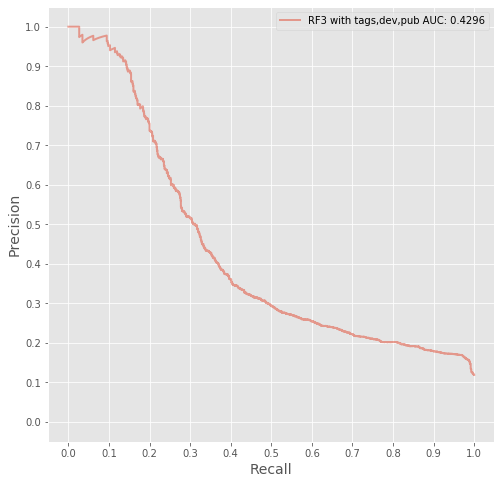

In [41]:
col_list = new_col_list.copy()

parameters_rf = {'n_estimators':[100,500,250],'max_features':['sqrt', 'log2',None], 'criterion':['gini', 'entropy'], 'max_depth':[3,4,5,6,7,8,9,10], 'min_impurity_decrease':list(np.arange(0,0.11,.01)) }
accuracy_rf3 = randomised_search_cv(RandomForestClassifier,parameters_rf,X_train,col_list,y_train,num_iter=20)
modelbuilder(RandomForestClassifier,accuracy_rf3[0],X_train,X_test,col_list,y_train,y_test,test_processed3,"RF3 with tags,dev,pub")


In [42]:
model3_parameters = accuracy_rf3[0]

model3_feature_set = new_col_list.copy()

model3_clf = RandomForestClassifier(**model3_parameters,random_state=42)
trained_model3 = model3_clf.fit(X_train[model3_feature_set], y_train)
print("Precision on train",precision_score(y_train,model3_clf.predict(X_train[model3_feature_set])) )
print("Recall on train",recall_score(y_train,model3_clf.predict(X_train[model3_feature_set]))) 
print("F1 score on train",f1_score(y_train,model3_clf.predict(X_train[model3_feature_set])) )
print("\n")
model3_df = pd.DataFrame()
model3_df['employee_id'] = train['employee_id']
model3_df['is_promoted'] = train['is_promoted']
model3_df['probability'] = [x[1] for x in model3_clf.predict_proba(train4[model3_feature_set])]
print("Average probability ",model3_df['probability'].mean())
print("\n")


for threshold in list(np.arange(0.1,0.5,.05))+[event_rate]:
    model3_df['threshold_'+str(threshold)+"pred"] = list(map(lambda x: 1 if x>= threshold else 0, model3_df['probability']))
    prec_score= precision_score(model3_df['is_promoted'],model3_df['threshold_'+str(threshold)+"pred"])
    rec_score= recall_score(model3_df['is_promoted'],model3_df['threshold_'+str(threshold)+"pred"])
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("threshold -> ", threshold)
    print("Precision on Full_data:",prec_score)
    print("Recall on Full_data:",rec_score)
    print("F1 Score on Full_data: ",f1)
    print(confusion_matrix(model3_df['is_promoted'], model3_df['threshold_'+str(threshold)+"pred"]))
    print("\n")
    

Precision on train 0.9229323308270677
Recall on train 0.14955833079500458
F1 score on train 0.25740498034076015


Average probability  0.08541980306604097


threshold ->  0.1
Precision on Full_data: 0.1958842943117841
Recall on Full_data: 0.8646101113967438
F1 Score on Full_data:  0.31940487496043046
[[33572 16568]
 [  632  4036]]


threshold ->  0.15000000000000002
Precision on Full_data: 0.2666418049599105
Recall on Full_data: 0.6126820908311911
F1 Score on Full_data:  0.37157334026243993
[[42274  7866]
 [ 1808  2860]]


threshold ->  0.20000000000000004
Precision on Full_data: 0.5374432677760969
Recall on Full_data: 0.30441302485004285
F1 Score on Full_data:  0.3886761487964989
[[48917  1223]
 [ 3247  1421]]


threshold ->  0.25000000000000006
Precision on Full_data: 0.6263959390862944
Recall on Full_data: 0.2643530419880034
F1 Score on Full_data:  0.37179873455860196
[[49404   736]
 [ 3434  1234]]


threshold ->  0.30000000000000004
Precision on Full_data: 0.7235939643347051
Recall

In [43]:
from feature_importance import data_vars, random_forest_feature_imp,vif_calc

In [44]:
woe_1,iv_1 = data_vars(train2[model1_feature_set],train['is_promoted'])
list_1_iv = list(iv_1[iv_1["IV"]>=0.02]['VAR_NAME'])

list_1_rf = random_forest_feature_imp(train2,model1_feature_set,train['is_promoted'],percentile=0.99)

list1_model = list(set(list_1_iv+list_1_rf))
len(list1_model)

Initial Number of features -> 59
Fit done
Final Number of features -> 29


29

In [45]:
woe_2,iv_2 = data_vars(train3[model2_feature_set],train['is_promoted'])
list_2_iv = list(iv_2[iv_2["IV"]>=0.02]['VAR_NAME'])

list_2_rf = random_forest_feature_imp(train3,model2_feature_set,train['is_promoted'],percentile=0.99)

list2_model = list(set(list_2_iv+list_2_rf))
len(list2_model)

Initial Number of features -> 11
Fit done
Final Number of features -> 4


4

In [46]:
woe_3,iv_3 = data_vars(train4[model3_feature_set],train['is_promoted'])
list_3_iv = list(iv_3[iv_3["IV"]>=0.02]['VAR_NAME'])

list_3_rf = random_forest_feature_imp(train4,model3_feature_set,train['is_promoted'],percentile=0.99)

list3_model = list(set(list_3_iv+list_3_rf))
len(list3_model)

Initial Number of features -> 570
Fit done
Final Number of features -> 256


328

In [47]:
tpot_full_data = pd.DataFrame()
tpot_full_data['employee_id'] = train['employee_id']
tpot_full_data['is_promoted'] = train['is_promoted']

tpot_full_data = pd.merge(tpot_full_data,train2[['employee_id']+list1_model],how='left',on='employee_id')
tpot_full_data = pd.merge(tpot_full_data,train3[['employee_id']+list2_model],how='left',on='employee_id')
tpot_full_data = pd.merge(tpot_full_data,train4[list3_model],how='left',left_index=True,right_index=True)

In [51]:
tpot_full_data_test = pd.DataFrame()
tpot_full_data_test['employee_id'] = test['employee_id']
# tpot_full_data['is_promoted'] = train['is_promoted']

tpot_full_data_test = pd.merge(tpot_full_data_test,test_processed[['employee_id']+list1_model],how='left',on='employee_id')
tpot_full_data_test = pd.merge(tpot_full_data_test,test_processed2[['employee_id']+list2_model],how='left',on='employee_id')
tpot_full_data_test = pd.merge(tpot_full_data_test,test_processed3[list3_model],how='left',left_index=True,right_index=True)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(tpot_full_data, tpot_full_data['is_promoted'], test_size=0.3, random_state=1)

In [49]:
len(list1_model+list2_model+list3_model),len(list(set(list1_model+list2_model+list3_model)))

(361, 361)

In [50]:
feature_set_tpot = list(set(list1_model+list2_model+list3_model))
len(feature_set_tpot)

361

0iterations ran
5iterations ran
10iterations ran
15iterations ran
({'n_estimators': 100, 'max_features': None, 'criterion': 'gini', 'max_depth': 6, 'min_impurity_decrease': 0.0}, 0.39546039499288116)
Precision on train 0.9184726522187823
Recall on train 0.27109351203167836
F1 score on train 0.4186265286923801
Precision on test: 0.9015151515151515
Recall on test: 0.25776173285198556
F1 Score on test:  0.4008983717012914
[[15019    39]
 [ 1028   357]]


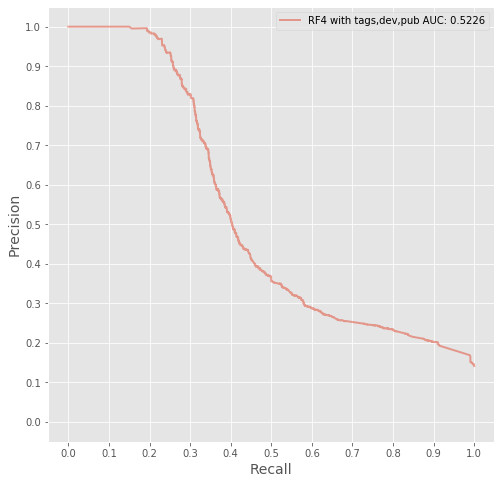

In [52]:
col_list = feature_set_tpot.copy()

parameters_rf = {'n_estimators':[100,500,250],'max_features':['sqrt', 'log2',None], 'criterion':['gini', 'entropy'], 'max_depth':[3,4,5,6,7,8,9,10], 'min_impurity_decrease':list(np.arange(0,0.11,.01)) }
accuracy_rf4 = randomised_search_cv(RandomForestClassifier,parameters_rf,X_train,col_list,y_train,num_iter=20)
modelbuilder(RandomForestClassifier,accuracy_rf4[0],X_train,X_test,col_list,y_train,y_test,tpot_full_data_test,"RF4 with tags,dev,pub")


In [54]:
model4_parameters = accuracy_rf4[0]

model4_feature_set = feature_set_tpot.copy()

model4_clf = RandomForestClassifier(**model4_parameters,random_state=42)
trained_model4 = model4_clf.fit(X_train[model4_feature_set], y_train)
print("Precision on train",precision_score(y_train,model4_clf.predict(X_train[model4_feature_set])))
print("Recall on train",recall_score(y_train,model4_clf.predict(X_train[model4_feature_set])))
print("F1 score on train",f1_score(y_train,model4_clf.predict(X_train[model4_feature_set])))
print("\n")
model4_df = pd.DataFrame()
model4_df['employee_id'] = train['employee_id']
model4_df['is_promoted'] = train['is_promoted']
model4_df['probability'] = [x[1] for x in model4_clf.predict_proba(tpot_full_data[model4_feature_set])]
print("Average probability ",model4_df['probability'].mean())
print("\n")


for threshold in list(np.arange(0.1,0.5,.05))+[event_rate]:
    model4_df['threshold_'+str(threshold)+"pred"] = list(map(lambda x: 1 if x>= threshold else 0, model4_df['probability']))
    prec_score= precision_score(model4_df['is_promoted'],model4_df['threshold_'+str(threshold)+"pred"])
    rec_score= recall_score(model4_df['is_promoted'],model4_df['threshold_'+str(threshold)+"pred"])
    f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
    print("threshold -> ", threshold)
    print("Precision on Full_data:",prec_score)
    print("Recall on Full_data:",rec_score)
    print("F1 Score on Full_data: ",f1)
    print(confusion_matrix(model4_df['is_promoted'], model4_df['threshold_'+str(threshold)+"pred"]))
    print("\n")
    

Precision on train 0.9167523124357657
Recall on train 0.27170271093512033
F1 score on train 0.4191729323308271


Average probability  0.08541729336646797


threshold ->  0.1
Precision on Full_data: 0.20770020032247033
Recall on Full_data: 0.9106683804627249
F1 Score on Full_data:  0.33825343147006165
[[33924 16216]
 [  417  4251]]


threshold ->  0.15000000000000002
Precision on Full_data: 0.2731535756154748
Recall on Full_data: 0.6988003427592117
F1 Score on Full_data:  0.3927754364840458
[[41460  8680]
 [ 1406  3262]]


threshold ->  0.20000000000000004
Precision on Full_data: 0.6870324189526185
Recall on Full_data: 0.35411311053984573
F1 Score on Full_data:  0.46734520780322303
[[49387   753]
 [ 3015  1653]]


threshold ->  0.25000000000000006
Precision on Full_data: 0.7914466737064414
Recall on Full_data: 0.32112253641816624
F1 Score on Full_data:  0.45687290460225544
[[49745   395]
 [ 3169  1499]]


threshold ->  0.30000000000000004
Precision on Full_data: 0.8502122498483929
Recal

<ol> <li> Model - 1 :- Old Features + RF</li>
    <li> Model - 2 :- New Features set 1+ RF </li>
    <li> Model - 3 :- New Features set (cont divided * multiplied) + RF </li>
    <li> Model - 4 :- IV sel, rf feat, RF </li>
    </ol>
<ul> <li> Ensembling predictions 0.5 normalized from f1 score </li>
    <li> ensembling add f1 weighted probabilities and cutoff analysis </li>
    <li> Ensemble of best predictions weighted then event_Rate </li>

In [147]:
m1_f1 = 0.5324937626232624
m2_f1 = 0.39457420338710975
m3_f1 = 0.3886761487964989
m4_f1 = 0.46734520780322303

threshold1 = 0.20000000000000004
threshold2 = 0.15000000000000002
threshold3 = 0.20000000000000004
threshold4 = 0.20000000000000004

w1,w2,w3,w4 = m1_f1/(m1_f1+m2_f1+m3_f1+m4_f1),m2_f1/(m1_f1+m2_f1+m3_f1+m4_f1),m3_f1/(m1_f1+m2_f1+m3_f1+m4_f1),m4_f1/(m1_f1+m2_f1+m3_f1+m4_f1)
print(w1,w2,w3,w4)

# sum_exp =np.exp(m1_f1)+np.exp(m2_f1)+np.exp(m3_f1)+np.exp(m4_f1)
# w1,w2,w3,w4 = np.exp(m1_f1)/sum_exp, np.exp(m2_f1)/sum_exp,np.exp(m3_f1)/sum_exp,np.exp(m4_f1)/sum_exp


# print(w1,w2,w3,w4)

0.2986354950764865 0.22128684098087148 0.21797906805226844 0.2620985958903736


In [73]:
final_analysis_train = pd.DataFrame()
final_analysis_train['employee_id'] = train['employee_id']
final_analysis_train['is_promoted'] = train['is_promoted']
final_analysis_train['p1'] = model1_df['probability']
final_analysis_train['p2'] = model2_df['probability']
final_analysis_train['p3'] = model3_df['probability']
final_analysis_train['p4'] = model4_df['probability']
final_analysis_train['pred1'] = model1_df['threshold_'+str(threshold1)+"pred"]
final_analysis_train['pred2'] = model2_df['threshold_'+str(threshold2)+"pred"]
final_analysis_train['pred3'] = model3_df['threshold_'+str(threshold3)+"pred"]
final_analysis_train['pred4'] = model4_df['threshold_'+str(threshold4)+"pred"]

final_analysis_train['weighted_p_v1'] = w1*final_analysis_train['p1'] + w2*final_analysis_train['p2'] + w3*final_analysis_train['p3'] + w4*final_analysis_train['p4']
final_analysis_train['weighted_pred'] = w1*final_analysis_train['pred1'] + w2*final_analysis_train['pred2'] + w3*final_analysis_train['pred3'] + w4*final_analysis_train['pred4']
final_analysis_train['weighted_p_v2'] = list(map(lambda x: 1 if x > 1 else x , final_analysis_train['weighted_pred']))




In [74]:
def calculating_scores(col):
    for threshold in list(np.arange(0.1,0.5,.05))+[event_rate]:
        final_analysis_train['threshold_'+str(threshold)+"pred"] = list(map(lambda x: 1 if x>= threshold else 0, final_analysis_train[col]))
        prec_score= precision_score(final_analysis_train['is_promoted'],final_analysis_train['threshold_'+str(threshold)+"pred"])
        rec_score= recall_score(final_analysis_train['is_promoted'],final_analysis_train['threshold_'+str(threshold)+"pred"])
        f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
        print("threshold -> ", threshold)
        print("Precision on Full_data:",prec_score)
        print("Recall on Full_data:",rec_score)
        print("F1 Score on Full_data: ",f1)
        print(confusion_matrix(final_analysis_train['is_promoted'], final_analysis_train['threshold_'+str(threshold)+"pred"]))
        print("\n")

In [75]:
calculating_scores('weighted_p_v1')

threshold ->  0.1
Precision on Full_data: 0.21306142267540665
Recall on Full_data: 0.9400171379605827
F1 Score on Full_data:  0.3473855044927364
[[33933 16207]
 [  280  4388]]


threshold ->  0.15000000000000002
Precision on Full_data: 0.3369668748015663
Recall on Full_data: 0.6820908311910883
F1 Score on Full_data:  0.45108734150315216
[[43875  6265]
 [ 1484  3184]]


threshold ->  0.20000000000000004
Precision on Full_data: 0.5789473684210527
Recall on Full_data: 0.4453727506426735
F1 Score on Full_data:  0.5034507809662188
[[48628  1512]
 [ 2589  2079]]


threshold ->  0.25000000000000006
Precision on Full_data: 0.8086696562032885
Recall on Full_data: 0.3476863753213368
F1 Score on Full_data:  0.48629213483146067
[[49756   384]
 [ 3045  1623]]


threshold ->  0.30000000000000004
Precision on Full_data: 0.8700854700854701
Recall on Full_data: 0.32712082262210795
F1 Score on Full_data:  0.47547874824848196
[[49912   228]
 [ 3141  1527]]


threshold ->  0.3500000000000001
Precision on 

In [76]:
calculating_scores('weighted_p_v2')

threshold ->  0.1
Precision on Full_data: 0.33347457627118643
Recall on Full_data: 0.6743787489288775
F1 Score on Full_data:  0.44627161893960876
[[43848  6292]
 [ 1520  3148]]


threshold ->  0.15000000000000002
Precision on Full_data: 0.33347457627118643
Recall on Full_data: 0.6743787489288775
F1 Score on Full_data:  0.44627161893960876
[[43848  6292]
 [ 1520  3148]]


threshold ->  0.20000000000000004
Precision on Full_data: 0.33347457627118643
Recall on Full_data: 0.6743787489288775
F1 Score on Full_data:  0.44627161893960876
[[43848  6292]
 [ 1520  3148]]


threshold ->  0.25000000000000006
Precision on Full_data: 0.525679068705775
Recall on Full_data: 0.49335904027420735
F1 Score on Full_data:  0.5090065200574649
[[48062  2078]
 [ 2365  2303]]


threshold ->  0.30000000000000004
Precision on Full_data: 0.5670073821692221
Recall on Full_data: 0.4278063410454156
F1 Score on Full_data:  0.48766788766788766
[[48615  1525]
 [ 2671  1997]]


threshold ->  0.3500000000000001
Precision o

In [65]:
final_analysis_train['random'] = list(map(lambda a,b,c,d: 1 if (a+b+c+d)>1 else 0, final_analysis_train['pred1'],final_analysis_train['pred2'],final_analysis_train['pred3'],final_analysis_train['pred4']))

In [66]:
prec_score= precision_score(final_analysis_train['is_promoted'],final_analysis_train['random'])
rec_score= recall_score(final_analysis_train['is_promoted'],final_analysis_train['random'])
f1 = 2*(prec_score*rec_score)/(prec_score+rec_score)
print("threshold -> ", threshold)
print("Precision on Full_data:",prec_score)
print("Recall on Full_data:",rec_score)
print("F1 Score on Full_data: ",f1)
print(confusion_matrix(final_analysis_train['is_promoted'],final_analysis_train['random']))
print("\n")

threshold ->  0.08517004816815063
Precision on Full_data: 0.5670073821692221
Recall on Full_data: 0.4278063410454156
F1 Score on Full_data:  0.48766788766788766
[[48615  1525]
 [ 2671  1997]]




In [129]:
woe_final,iv_final = data_vars(tpot_full_data[model4_feature_set],final_analysis_train['is_promoted'])

In [130]:
iv_final[iv_final['IV']>=0.02].head(20)

,VAR_NAME,IV
110,avg_training_score_mul_sum_metric,7.937456
306,sum_metric_mul_avg_training_score,7.937456
299,sum_metric_div_start_year,6.498551
71,age_div_sum_metric,6.191344
290,sum_metric_div_age,6.083859
312,sum_metric_mul_start_year,5.716122
285,start_year_mul_sum_metric,5.716122
337,tot_score_mul_sum_metric,5.596956
314,sum_metric_mul_tot_score,5.596956
275,start_year_div_sum_metric,5.543810


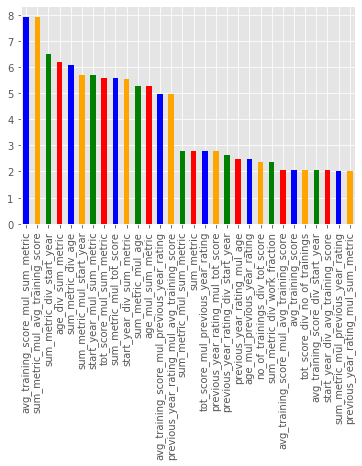

In [133]:
data_iv = pd.Series(iv_final[iv_final['IV']>=0.02]['IV'].values,index=iv_final[iv_final['IV']>=0.02]['VAR_NAME'].values)

data_iv.nlargest(30).plot(kind='bar',color=['blue', 'orange', 'green', 'red'])

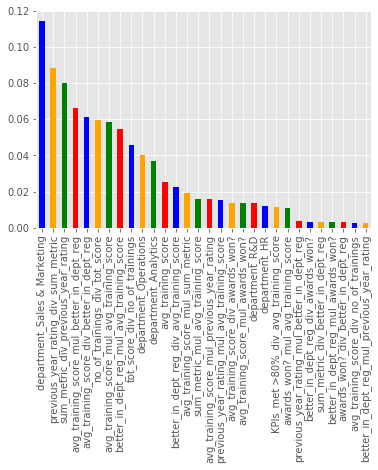

In [134]:
feat_importances = pd.Series(model4_clf.feature_importances_, index=model4_feature_set)
feat_importances.nlargest(30).plot(kind='bar',color=['blue', 'orange', 'green', 'red'])

### Final Predictions on Test Data and Submission

I have choosen four models for final submission:<br>
<ol><li> Model 1 with 0.2 threshold </li>
    <li> Weighted ensemble probability at 0.2 threshold </li>
    <li> Weighted Predictions at 0.25 threshold </li>
    <li> Voting from all 4 models </li>
</ol>

In [148]:
final_analysis_test = pd.DataFrame()
final_analysis_test['employee_id'] = test['employee_id']
# final_analysis_test['is_promoted'] = test['is_promoted']
final_analysis_test['p1'] = [x[1] for x in model1_clf.predict_proba(test_processed[model1_feature_set])]
final_analysis_test['p2'] = [x[1] for x in model2_clf.predict_proba(test_processed2[model2_feature_set])]
final_analysis_test['p3'] = [x[1] for x in model3_clf.predict_proba(test_processed3[model3_feature_set])]
final_analysis_test['p4'] = [x[1] for x in model4_clf.predict_proba(tpot_full_data_test[model4_feature_set])]
final_analysis_test['pred1'] = model1_df['threshold_'+str(threshold1)+"pred"]
final_analysis_test['pred2'] = model2_df['threshold_'+str(threshold2)+"pred"]
final_analysis_test['pred3'] = model3_df['threshold_'+str(threshold3)+"pred"]
final_analysis_test['pred4'] = model4_df['threshold_'+str(threshold4)+"pred"]

final_analysis_test['weighted_p_v1'] = w1*final_analysis_test['p1'] + w2*final_analysis_test['p2'] + w3*final_analysis_test['p3'] + w4*final_analysis_test['p4']
final_analysis_test['weighted_pred'] = w1*final_analysis_test['pred1'] + w2*final_analysis_test['pred2'] + w3*final_analysis_test['pred3'] + w4*final_analysis_test['pred4']
final_analysis_test['weighted_p_v2'] = list(map(lambda x: 1 if x > 1 else x , final_analysis_test['weighted_pred']))


##### Model 1 

In [143]:
test1 = pd.DataFrame()
test1['employee_id'] = test['employee_id']
test1['prob'] = final_analysis_test['weighted_p_v1']
test1['is_promoted'] = list(map(lambda x: 1 if x>= 0.2 else 0, test1['prob']))
print(test1['is_promoted'].mean(),test1['prob'].mean())
test1[['employee_id','is_promoted']].to_csv("../submissions/SubmissionFinal_m1_v1.csv",index=False)

0.06347381864623244 0.08471212257650507


In [140]:
print("Final Score on Analytics Vidhya Portal -> ",0.4832022873481058 )

Final Score on Analytics Vidhya Portal ->  0.4832022873481058


##### Model 2

In [149]:
test2 = pd.DataFrame()
test2['employee_id'] = test['employee_id']
test2['prob'] = final_analysis_test['weighted_p_v1']
test2['is_promoted'] = list(map(lambda x: 1 if x>= 0.2 else 0, test2['prob']))
print(test2['is_promoted'].mean(),test2['prob'].mean())
test2[['employee_id','is_promoted']].to_csv("../submissions/SubmissionFinal_m2_v1.csv",index=False)

0.06347381864623244 0.08471212257650507


In [145]:
print("Final Score on Analytics Vidhya Portal -> ", 0.460431654676259)

Final Score on Analytics Vidhya Portal ->  0.460431654676259


#### Model 3

In [150]:
test3 = pd.DataFrame()
test3['employee_id'] = test['employee_id']
test3['prob'] = final_analysis_test['weighted_p_v2']
test3['is_promoted'] = list(map(lambda x: 1 if x>= 0.25 else 0, test3['prob']))
print(test3['is_promoted'].mean(),test3['prob'].mean())
test3[['employee_id','is_promoted']].to_csv("../submissions/SubmissionFinal_m3_v1.csv",index=False)

0.0789272030651341 0.0738428795406831


In [151]:
print("Final Score on Analytics Vidhya Portal -> ", 0.07436399217221135)

Final Score on Analytics Vidhya Portal ->  0.07436399217221135


#### Model 4

In [153]:
test4 = pd.DataFrame()
test4['employee_id'] = test['employee_id']
# test4['prob'] = final_analysis_test['weighted_p_v2']
test4['is_promoted'] = list(map(lambda a,b,c,d: 1 if (a+b+c+d)>1 else 0, final_analysis_test['pred1'],final_analysis_test['pred2'],final_analysis_test['pred3'],final_analysis_test['pred4']))
print(test4['is_promoted'].mean())
test4[['employee_id','is_promoted']].to_csv("../submissions/SubmissionFinal_m4_v1.csv",index=False)

0.06389953171562367


In [154]:
print("Final Score on Analytics Vidhya Portal -> ", 0.0756363636363637)

Final Score on Analytics Vidhya Portal ->  0.0756363636363637
